# Final Project for AI 221

AI 221 | 1st Sem AY 2024-2025  
Students: Jemima Bian Anila, Joshua Cantor, Michael Spencer Quinto, MEng in AI  
Instructors: Dr. Miguel Remolona | Dr. Jon Dewitt Dalisay

## Dataset

https://data.mendeley.com/datasets/tsvdyhbphs/1

https://www.kaggle.com/datasets/jaydepaolomirandilla/philippine-medicinal-plant-leaf-dataset/data


In [3]:
import sys
from pathlib import Path
  
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
import torch
import random
import os
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import re
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.svm import SVC
import cv2
from skimage.feature import hog, local_binary_pattern
from skimage import io, color
import scipy.ndimage as nd
import pywt
import mahotas as mt
import concurrent.futures


%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True, precision=3)

In [4]:
# Add project root directory to Python path to allow importing from src folder
notebook_dir = Path("__file__").resolve().parent
project_root = Path.cwd().parent
sys.path.append(str(project_root))


from src.utils_classical import feature_reduction
from src.utils_plotting import create_classification_report

In [5]:
# Check if a GPU is available
if torch.cuda.is_available():
    print("GPU is available")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not available")

GPU is available
GPU Name: NVIDIA GeForce RTX 4060 Laptop GPU


# Import utility modules from `src` folder

Note: all reusable code like transformations for the dataframes, etc. can be found inside the `src` folder and are imported here for better modularity and version control


In [4]:
from src.utils_nn import SampleNN, test_function
from src.utils_image_conversion import (
    PROCESSED_DATA_FOLDER,
    HIBISCUS_PROCESSED_FOLDER,
    CARMONA_RETUSA_PROCESSED_FOLDER,
    AVERRHOEA_BILIMBI_PROCESSED_FOLDER,
)
from src.utils_preprocessing import detect_edges_and_lines

In [5]:
print(PROCESSED_DATA_FOLDER.relative_to(project_root))
print(HIBISCUS_PROCESSED_FOLDER.relative_to(project_root))

data\ph_med_plants_reduced_sizes
data\ph_med_plants_reduced_sizes\1Hibiscus rosa-sinensis(HRS)


# 1. Exploratory Data Analysis


## 1.1 Data Loading and Inspection


In [6]:
# Get list of files in HIBISCUS_PROCESSED_FOLDER
hibiscus_files = list(HIBISCUS_PROCESSED_FOLDER.glob("*.webp"))
hibiscus_files_names = [file.name for file in hibiscus_files]
print(hibiscus_files_names)

['Class1_1.webp', 'Class1_10.webp', 'Class1_100.webp', 'Class1_101.webp', 'Class1_102.webp', 'Class1_103.webp', 'Class1_104.webp', 'Class1_105.webp', 'Class1_106.webp', 'Class1_107.webp', 'Class1_108.webp', 'Class1_109.webp', 'Class1_11.webp', 'Class1_110.webp', 'Class1_111.webp', 'Class1_112.webp', 'Class1_113.webp', 'Class1_114.webp', 'Class1_115.webp', 'Class1_116.webp', 'Class1_12.webp', 'Class1_13.webp', 'Class1_14.webp', 'Class1_15.webp', 'Class1_16.webp', 'Class1_17.webp', 'Class1_18.webp', 'Class1_19.webp', 'Class1_2.webp', 'Class1_20.webp', 'Class1_21.webp', 'Class1_22.webp', 'Class1_23.webp', 'Class1_24.webp', 'Class1_25.webp', 'Class1_26.webp', 'Class1_27.webp', 'Class1_28.webp', 'Class1_29.webp', 'Class1_3.webp', 'Class1_30.webp', 'Class1_31.webp', 'Class1_32.webp', 'Class1_33.webp', 'Class1_34.webp', 'Class1_35.webp', 'Class1_36.webp', 'Class1_37.webp', 'Class1_38.webp', 'Class1_39.webp', 'Class1_4.webp', 'Class1_40.webp', 'Class1_41.webp', 'Class1_42.webp', 'Class1_43.web

In [7]:
# Total number of (all ) images
# Get total number of images across all classes
# Get total number of images across all subfolders
total_images = sum(
    len(list(folder.glob("*.webp")))
    for folder in PROCESSED_DATA_FOLDER.iterdir()
    if folder.is_dir()
)
print(f"Total number of images: {total_images}")
print("--------------------------------")

# Get number of images per subfolder
for folder in PROCESSED_DATA_FOLDER.iterdir():
    if folder.is_dir():
        num_images = len(list(folder.glob("*.webp")))
        print(f"{folder.name}: {num_images} images")

print("--------------------------------")
# Get total number of folders
num_folders = sum(1 for folder in PROCESSED_DATA_FOLDER.iterdir() if folder.is_dir())
print(f"\nTotal number of folders: {num_folders}")

Total number of images: 4971
--------------------------------
10Coleus scutellarioides(CS): 120 images
11Phyllanthus niruri(PN): 130 images
12Corchorus olitorius(CO): 142 images
13Momordica charantia (MC): 106 images
14Euphorbia hirta(EH): 128 images
15Curcuma longa(CL): 100 images
16Carmona retusa(CR): 130 images
17Senna alata(SA): 118 images
18Mentha cordifolia Opiz(MCO): 100 images
19Capsicum frutescens(CF): 126 images
1Hibiscus rosa-sinensis(HRS): 116 images
20Jatropha curcas(JC): 142 images
21Ocimum basilicum(OB): 148 images
22Nerium oleander(NO): 130 images
23Pandanus amaryllifolius(PA): 108 images
24Aloe barbadensis Miller(ABM): 130 images
25Lagerstroemia speciosa(LS): 140 images
26Averrhoea bilimbi(AVB): 100 images
27Annona muricata(AM): 120 images
28Citrus aurantiifolia(CIA): 116 images
29Premna odorata(PO): 120 images
2Psidium guajava(PG): 110 images
30Gliricidia sepium(GS): 130 images
31Citrus sinensis(CIS): 100 images
32Mangifera indica(MI): 110 images
33Citrus microcarpa(C

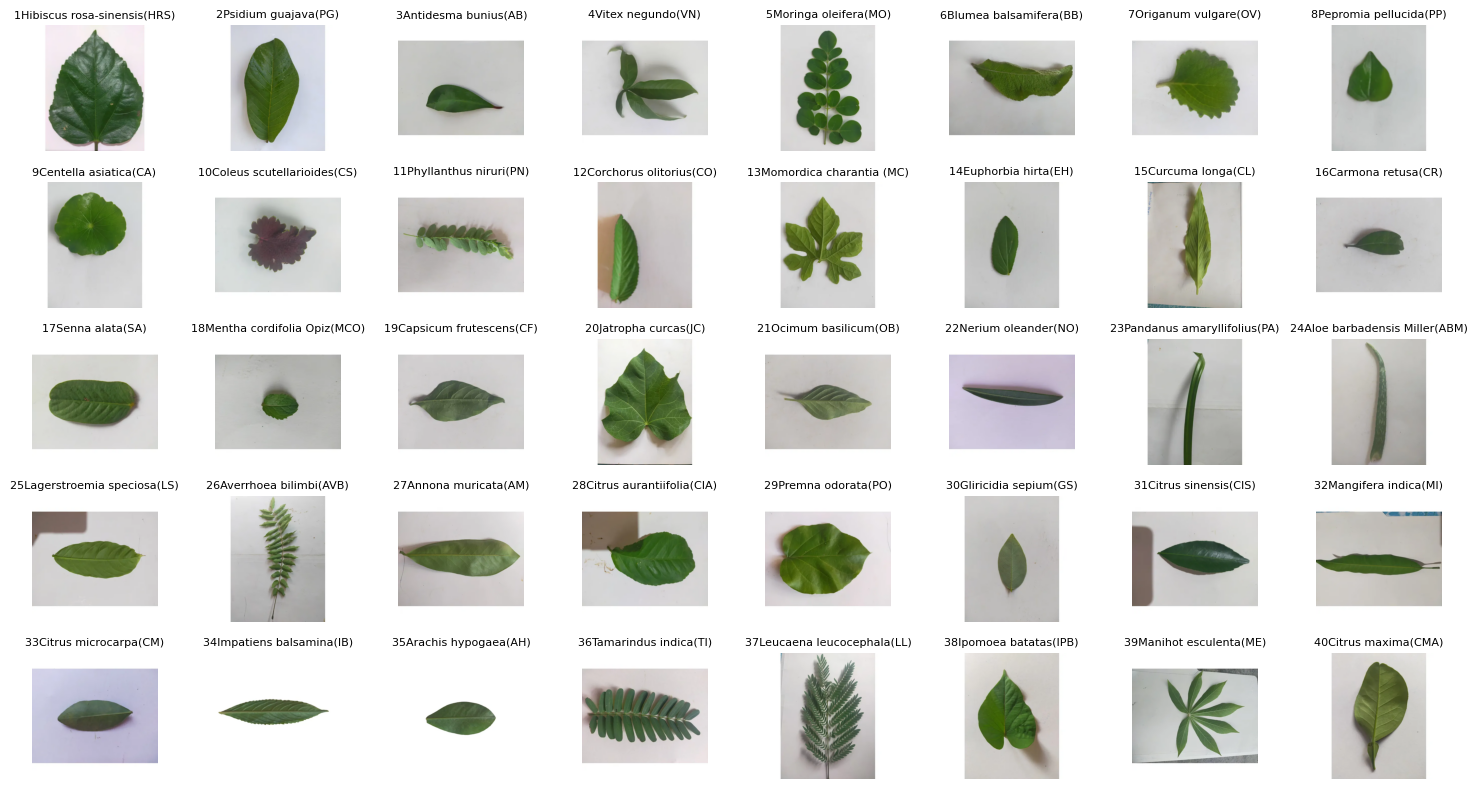

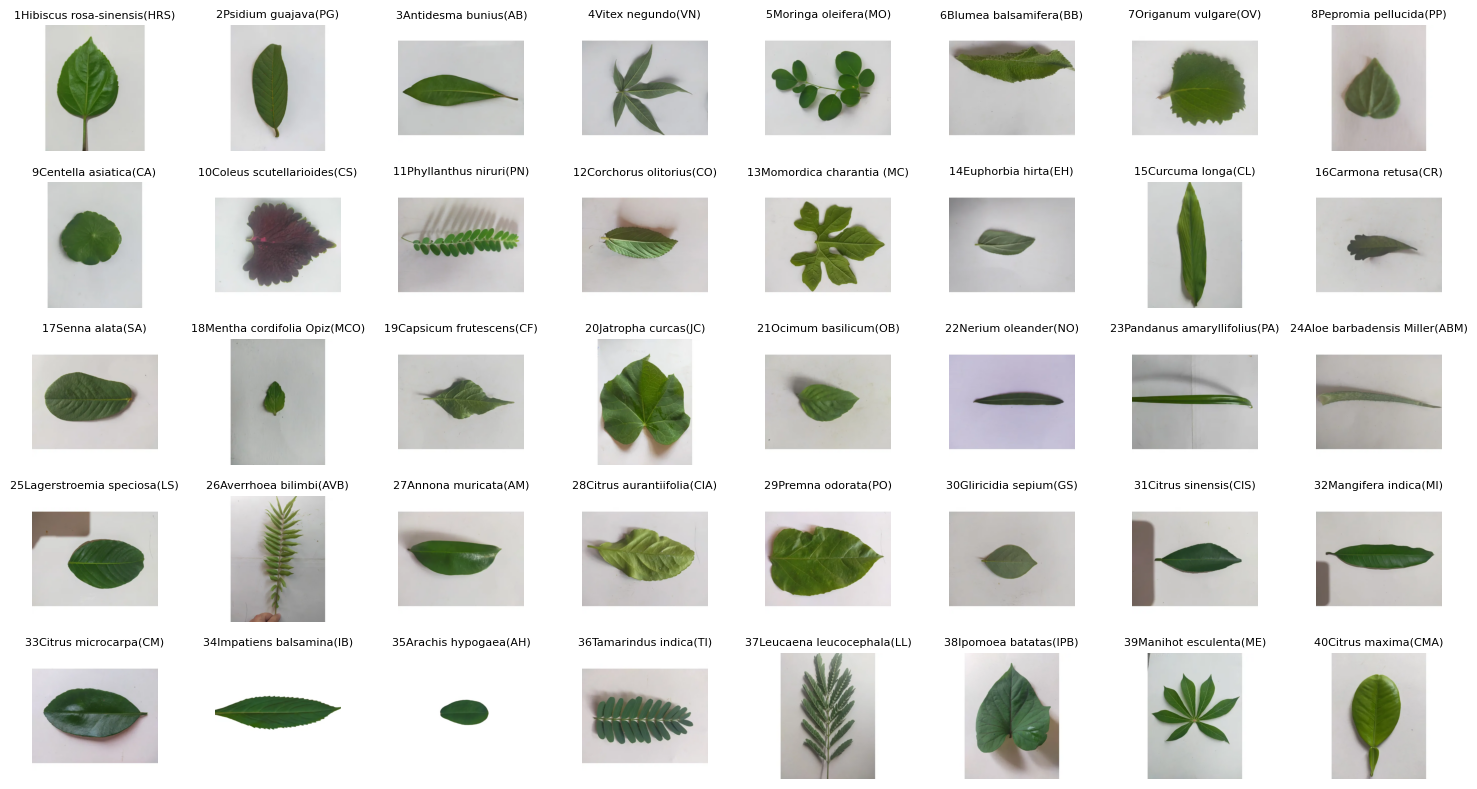

In [34]:
from src.utils_data import (
    plot_random_raw_images_grid,
    class_folders,
    get_random_images_from_each_class,
    RAW_DATA_DF,
)


# get 1 random image from each class folder (40 images in total)
plot_random_raw_images_grid(class_folders)
plot_random_raw_images_grid(class_folders)

In [ ]:
# Load the pre-trained VGG19 model and remove the classifier part for feature extraction
model = models.vgg19(pretrained=True)
model = nn.Sequential(*list(model.children())[:-1])  # Keep only the feature extraction part
model.eval()  # Set the model to evaluation mode

# Transformation for input images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to 224x224 as required by VGG19
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet values
])

# Function to extract features from an image
def extract_features(img_path, model):
    image = Image.open(img_path).convert('RGB')  # Ensure 3-channel RGB format
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    
    with torch.no_grad():  # No need to compute gradients for inference
        features = model(image)
    
    return features.flatten().numpy()  # Convert to 1D NumPy array for storage


# Path to the main dataset folder containing 40 subfolders for each plant
main_dataset_path = '../data/ph_med_plants_reduced_sizes'

# Prepare lists to store features and labels
features_list = []
labels_list = []

# Loop through each plant folder
for plant_folder in os.listdir(main_dataset_path):
    plant_folder_path = os.path.join(main_dataset_path, plant_folder)
    
    if os.path.isdir(plant_folder_path):  # Check if it is a directory (i.e., a folder for a plant)
        for img_name in os.listdir(plant_folder_path):
            img_path = os.path.join(plant_folder_path, img_name)
            
            # Ensure it's an image file, including .webp
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.webp')):
                try:
                    # Extract features and append to the list
                    features = extract_features(img_path, model)
                    features_list.append(features)
                    
                    # Append the label (folder name as plant label)
                    labels_list.append(plant_folder)
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")

# Convert features and labels to NumPy arrays for further analysis
features_array = np.array(features_list)
labels_array = np.array(labels_list)
labels_array = np.array([re.sub(r'^\d+', '', item) for item in labels_array])
target_names = np.unique(labels_array).tolist()

print("Feature extraction complete.")
print("Shape of feature array:", features_array.shape)
print("Number of labels:", labels_array.shape)

# Save the features array to disk
np.save('../data/features.npy', features_array)

# Save the labels array to disk
np.save('../data/labels.npy', labels_array)

# Save the target names array to disk
np.save('../data/target_names.npy', target_names)

print("Arrays saved to disk successfully.")

Feature extraction complete.
Shape of feature array: (4971, 25088)
Number of labels: (4971,)


In [ ]:
features_array = np.load('../data/features.npy')
labels_array = np.load('../data/labels.npy')
target_names = np.load('../data/target_names.npy')
target_names = np.unique(labels_array).tolist()

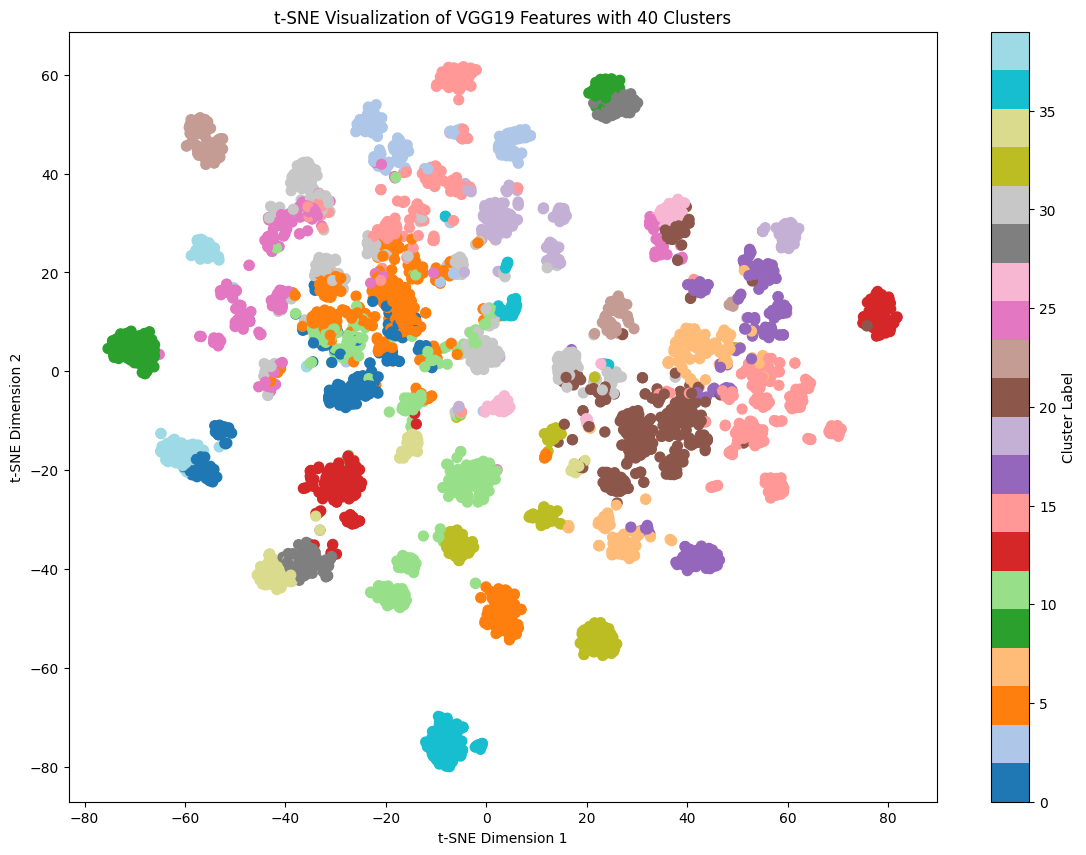

In [3]:
# Apply KMeans clustering with 40 clusters
kmeans = KMeans(n_clusters=40, random_state=42)
cluster_labels = kmeans.fit_predict(features_array)

# Reduce dimensionality for visualization using t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(features_array)

# Visualize the clusters
plt.figure(figsize=(14, 10))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=cluster_labels, cmap='tab20', s=50)
plt.colorbar(scatter, label='Cluster Label')
plt.title('t-SNE Visualization of VGG19 Features with 40 Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

                              precision    recall  f1-score   support

Aloe barbadensis Miller(ABM)       1.00      1.00      1.00        33
         Annona muricata(AM)       0.97      0.94      0.96        36
        Antidesma bunius(AB)       0.92      1.00      0.96        36
        Arachis hypogaea(AH)       1.00      1.00      1.00        42
      Averrhoea bilimbi(AVB)       0.93      1.00      0.96        25
      Blumea balsamifera(BB)       0.97      0.97      0.97        29
     Capsicum frutescens(CF)       1.00      0.98      0.99        45
          Carmona retusa(CR)       0.95      0.97      0.96        39
       Centella asiatica(CA)       1.00      1.00      1.00        41
   Citrus aurantiifolia(CIA)       0.91      0.97      0.94        32
          Citrus maxima(CMA)       0.97      0.88      0.92        34
       Citrus microcarpa(CM)       0.93      0.89      0.91        28
        Citrus sinensis(CIS)       0.91      0.94      0.92        32
  Coleus scutellari

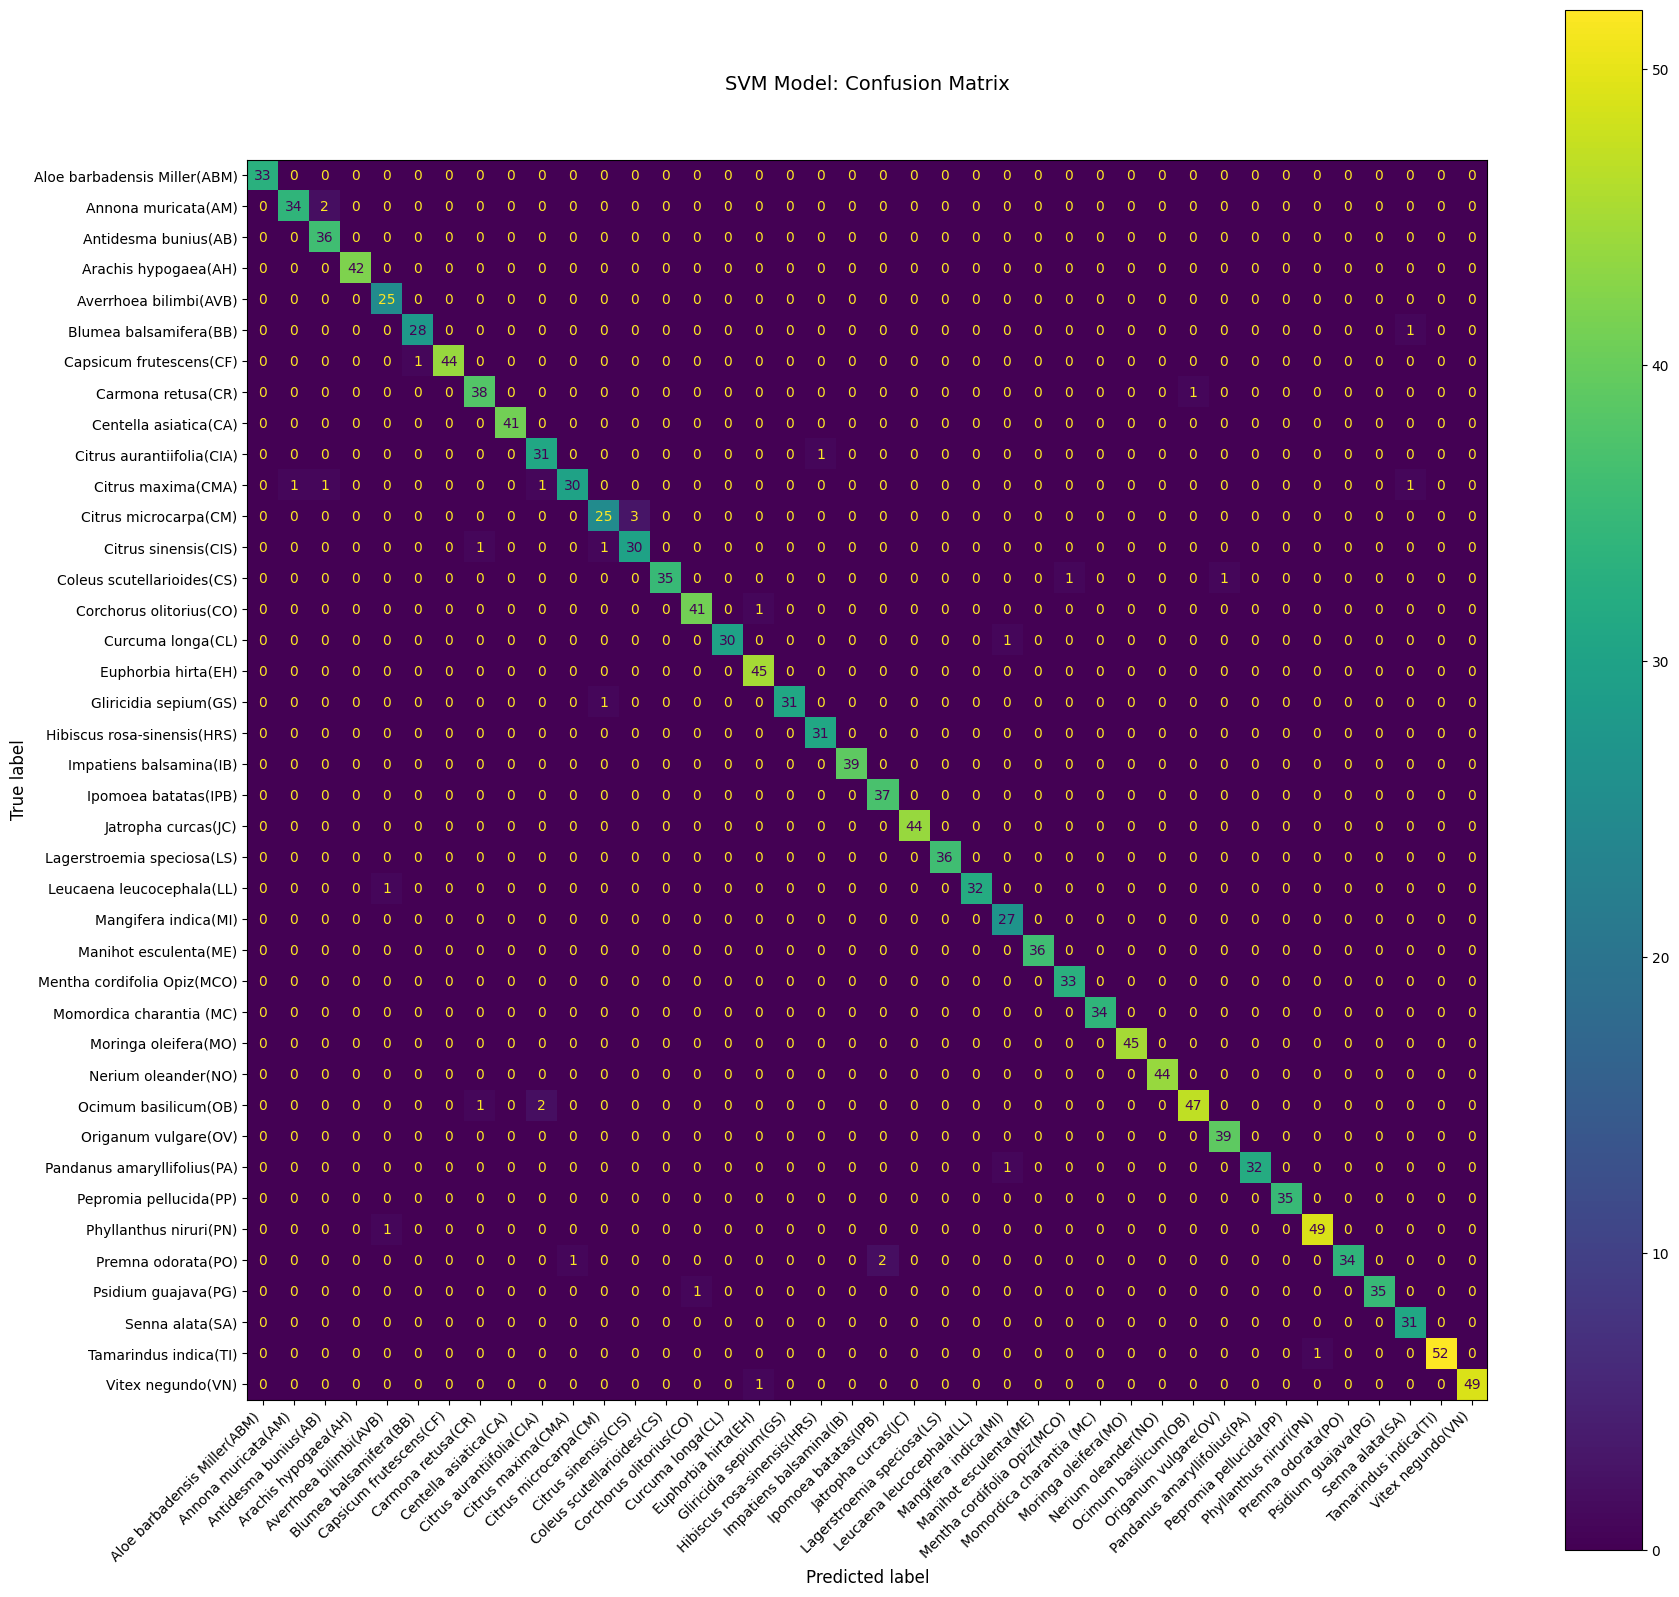

In [33]:
X_train, X_test, y_train, y_test = feature_reduction(features_array, labels_array, method='pca', n_components=0.95)

model = SVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

create_classification_report(y_test, y_pred, target_names, "SVM Model")

### Traditional Feature Selection/Extraction

In [65]:
# Apply Gabor filters for texture analysis
def build_gabor_filters() -> list[np.ndarray]:
    """Build Gabor filters with different orientations and frequencies.

    Returns:
        list[np.ndarray]: List of Gabor kernels
    """
    filters: list[np.ndarray] = []
    ksize: int = 31  # Kernel size
    sigma: float = 3.0  # Standard deviation of Gaussian envelope
    lambda_min: float = 4.0  # Minimum wavelength
    lambda_max: float = 10.0  # Maximum wavelength
    num_thetas: int = 8  # Number of orientations
    num_lambdas: int = 5  # Number of wavelengths

    # Generate filters for different orientations and wavelengths
    for theta in np.linspace(0, np.pi, num_thetas):
        for lambda_ in np.linspace(lambda_min, lambda_max, num_lambdas):
            kernel = cv2.getGaborKernel(
                (ksize, ksize),
                sigma=sigma,
                theta=theta,
                lambd=lambda_,
                gamma=0.5,  # Spatial aspect ratio
                psi=0,  # Phase offset
            )
            kernel /= 1.5 * kernel.sum()
            filters.append(kernel)
    return filters


def apply_gabor_filters(
    image: np.ndarray, filters: list[np.ndarray]
) -> tuple[np.ndarray, list[np.ndarray]]:
    """Apply Gabor filters to an image.

    Args:
        image: Input grayscale image
        filters: List of Gabor kernels

    Returns:
        tuple containing:
            - Combined filtered image
            - List of individual filter responses
    """
    responses: list[np.ndarray] = []
    for kernel in filters:
        response = cv2.filter2D(image, cv2.CV_32F, kernel)
        feature_vector = response.flatten()
        responses.append(feature_vector)

    # Combine responses
    combined = np.sqrt(
        np.sum(np.array([response**2 for response in responses]), axis=0)
    )
    return combined, np.concatenate(responses)


# Generate Gabor filters
gabor_filters = build_gabor_filters()

In [ ]:
# Function to extract features from an image
def extract_features_traditional(image_path):
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # HOG features
    hog_features, _ = hog(gray_image, orientations=9, pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2), visualize=True)
    print(hog_features.shape)
    
    # SIFT features
    sift = cv2.SIFT_create()
    _, sift_features = sift.detectAndCompute(gray_image, None)
    sift_features = sift_features.flatten() if sift_features is not None else np.zeros(128)
    print(sift_features.shape)
    
    # ORB features
    orb = cv2.ORB_create()
    _, orb_features = orb.detectAndCompute(gray_image, None)
    orb_features = orb_features.flatten() if orb_features is not None else np.zeros(32)
    print(orb_features.shape)

    # Color histogram features
    color_histogram = np.concatenate([
        np.histogram(image[:, :, i], bins=32, range=(0, 256))[0] for i in range(3)
    ])
    print(color_histogram.shape)
    
    # LBP features
    radius = 3
    n_points = 8 * radius
    lbp_features = local_binary_pattern(gray_image, n_points, radius, method='uniform').flatten()
    print(lbp_features.shape)

    # Gabor features
    gabor_combined, gabor_responses = apply_gabor_filters(gray_image, gabor_filters)
    print(gabor_responses.shape)

    # Wavelet transform features
    coeffs = pywt.dwt2(gray_image, 'db1')
    # Extract the approximation and detail coefficients
    cA, (cH, cV, cD) = coeffs

    # Flatten and concatenate all coefficients
    wavelet_features = np.hstack([cA.flatten(), cH.flatten(), cV.flatten(), cD.flatten()])
    print(wavelet_features.shape)

    # Combine all features
    combined_features = np.hstack([
        hog_features, sift_features, orb_features,
        color_histogram, lbp_features, gabor_responses, wavelet_features
    ])
    
    return combined_features

# Path to the main dataset folder containing 40 subfolders for each plant
main_dataset_path = '../data/ph_med_plants_reduced_sizes'

# Prepare lists to store features and labels
features_list = []
labels_list = []

# Loop through each plant folder
for plant_folder in os.listdir(main_dataset_path):
    plant_folder_path = os.path.join(main_dataset_path, plant_folder)
    
    if os.path.isdir(plant_folder_path):  # Check if it is a directory (i.e., a folder for a plant)
        for img_name in os.listdir(plant_folder_path):
            img_path = os.path.join(plant_folder_path, img_name)
            
            # Ensure it's an image file, including .webp
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.webp')):
                try:
                    # Extract features and append to the list
                    features = extract_features_traditional(img_path)
                    features_list.append(features)
                    
                    # Append the label (folder name as plant label)
                    labels_list.append(plant_folder)
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")
            break
    break

# Convert features and labels to NumPy arrays for further analysis
features_array_traditional = np.array(features_list)
labels_array_traditional = np.array(labels_list)
labels_array_traditional = np.array([re.sub(r'^\d+', '', item) for item in labels_array_traditional])
target_names_traditional = np.unique(labels_array_traditional).tolist()

print("Feature extraction complete.")
print("Shape of feature array:", features_array_traditional.shape)
print("Number of labels:", labels_array_traditional.shape)

# Save the features array to disk
np.save('../data/features_traditional.npy', features_array_traditional)

# Save the labels array to disk
np.save('../data/labels_traditional.npy', labels_array_traditional)

# Save the target names array to disk
np.save('../data/target_names_traditional.npy', target_names_traditional)

print("Arrays saved to disk successfully.")

(133956,)
(17024,)
(16000,)
(96,)
(250000,)
(10000000,)
(250000,)
Feature extraction complete.
Shape of feature array: (1, 10667076)
Number of labels: (1,)
Arrays saved to disk successfully.


In [ ]:
# Function to extract features from an image
def extract_morphological_features(image_path):
    image = plt.imread(image_path)                
    
    # Convert the image to RGB
    color_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert the image to Grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Perform thresholding
    _, thresholded = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Get the largest contour (assumed to be the leaf)
    leaf_contour = max(contours, key=cv2.contourArea)

    # Shape based features
    x, y, w, h = cv2.boundingRect(leaf_contour)
    area = cv2.contourArea(leaf_contour)
    perimeter = cv2.arcLength(leaf_contour, True)
    x, y, w, h = cv2.boundingRect(leaf_contour)
    physiological_length = max(w, h)
    physiological_width = min(w, h)
    aspect_ratio = float(physiological_length) / physiological_width
    rectangularity = area / (physiological_length * physiological_width)
    circularity = (4 * np.pi * area) / (perimeter ** 2)
    convex_area = cv2.contourArea(cv2.convexHull(leaf_contour))
    convex_ratio = area / convex_area

    # Color based features
    b, g, r = cv2.split(color_image)

    # Calculate mean and standard deviation for each channel
    mean_b = np.mean(b)
    mean_g = np.mean(g)
    mean_r = np.mean(r)

    std_b = np.std(b)
    std_g = np.std(g)
    std_r = np.std(r)

    # Texture based features
    textures = mt.features.haralick(gray_image)
    ht_mean = textures.mean(axis=0)
    contrast = ht_mean[1]
    correlation = ht_mean[2]
    inverse_diff_moments = ht_mean[4]
    entropy = ht_mean[8]
    vector = [area,perimeter,physiological_length,physiological_width,aspect_ratio,rectangularity,circularity,w,h,convex_area,convex_ratio,
            mean_r,mean_g,mean_b,std_r,std_g,std_b,
            contrast,correlation,inverse_diff_moments,entropy,
            ]
    return vector
# Path to the main dataset folder containing 40 subfolders for each plant
main_dataset_path = '../data/ph_med_plants_reduced_sizes'

# Prepare lists to store features and labels
features_list = []
labels_list = []

# Loop through each plant folder
for plant_folder in os.listdir(main_dataset_path):
    plant_folder_path = os.path.join(main_dataset_path, plant_folder)
    
    if os.path.isdir(plant_folder_path):  # Check if it is a directory (i.e., a folder for a plant)
        for img_name in os.listdir(plant_folder_path):
            img_path = os.path.join(plant_folder_path, img_name)
            
            # Ensure it's an image file, including .webp
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.webp')):
                try:
                    # Extract features and append to the list
                    features = extract_morphological_features(img_path)
                    features_list.append(features)
                    
                    # Append the label (folder name as plant label)
                    labels_list.append(plant_folder)
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")

# Convert features and labels to NumPy arrays for further analysis
features_array_morphological = np.array(features_list)
labels_array_morphological = np.array(labels_list)
labels_array_morphological = np.array([re.sub(r'^\d+', '', item) for item in labels_array_morphological])
target_names_morphological = np.unique(labels_array_morphological).tolist()

print("Feature extraction complete.")
print("Shape of feature array:", features_array_morphological.shape)
print("Number of labels:", labels_array_morphological.shape)

# Save the features array to disk
np.save('../data/features_morphological.npy', features_array_morphological)

# Save the labels array to disk
np.save('../data/labels_morphological.npy', labels_array_morphological)

# Save the target names array to disk
np.save('../data/target_names_morphological.npy', target_names_morphological)

print("Arrays saved to disk successfully.")

Error processing ../data/ph_med_plants_reduced_sizes\28Citrus aurantiifolia(CIA)\Class28­_1.webp: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

Error processing ../data/ph_med_plants_reduced_sizes\28Citrus aurantiifolia(CIA)\Class28­_10.webp: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

Error processing ../data/ph_med_plants_reduced_sizes\28Citrus aurantiifolia(CIA)\Class28­_100.webp: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'

Error processing ../data/ph_med_plants_reduced_sizes\28Citrus aurantiifolia(CIA)\Class28­_101.webp: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion f

KeyboardInterrupt: 

In [95]:
# Function to extract features from an image
def extract_morphological_features(image_path):
    image = plt.imread(image_path)                
    
    # Convert the image to RGB
    color_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert the image to Grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Perform thresholding
    _, thresholded = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Get the largest contour (assumed to be the leaf)
    leaf_contour = max(contours, key=cv2.contourArea)

    # Shape based features
    x, y, w, h = cv2.boundingRect(leaf_contour)
    area = cv2.contourArea(leaf_contour)
    perimeter = cv2.arcLength(leaf_contour, True)
    x, y, w, h = cv2.boundingRect(leaf_contour)
    physiological_length = max(w, h)
    physiological_width = min(w, h)
    aspect_ratio = float(physiological_length) / physiological_width
    rectangularity = area / (physiological_length * physiological_width)
    circularity = (4 * np.pi * area) / (perimeter ** 2)
    convex_area = cv2.contourArea(cv2.convexHull(leaf_contour))
    convex_ratio = area / convex_area

    # Color based features
    b, g, r = cv2.split(color_image)

    # Calculate mean and standard deviation for each channel
    mean_b = np.mean(b)
    mean_g = np.mean(g)
    mean_r = np.mean(r)

    std_b = np.std(b)
    std_g = np.std(g)
    std_r = np.std(r)

    # Texture based features
    textures = mt.features.haralick(gray_image)
    ht_mean = textures.mean(axis=0)
    contrast = ht_mean[1]
    correlation = ht_mean[2]
    inverse_diff_moments = ht_mean[4]
    entropy = ht_mean[8]
    vector = [area,perimeter,physiological_length,physiological_width,aspect_ratio,rectangularity,circularity,w,h,convex_area,convex_ratio,
            mean_r,mean_g,mean_b,std_r,std_g,std_b,
            contrast,correlation,inverse_diff_moments,entropy,
            ]
    return vector

# Function to process an image and extract features
def process_image(img_path, plant_folder):
    try:
        # Extract features and return as a tuple (features, label)
        features = extract_morphological_features(img_path)
        return features, plant_folder
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return None

# Main function to process images concurrently
def process_images_concurrently(main_dataset_path):
    with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
        futures = []
        
        # Loop through each plant folder
        for plant_folder in os.listdir(main_dataset_path):
            plant_folder_path = os.path.join(main_dataset_path, plant_folder)

            if os.path.isdir(plant_folder_path):  # Check if it is a directory (i.e., a folder for a plant)
                for img_name in os.listdir(plant_folder_path):
                    img_path = os.path.join(plant_folder_path, img_name)

                    # Ensure it's an image file, including .webp
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.webp')):
                        futures.append(
                            executor.submit(process_image, img_path, plant_folder)
                        )

        # Collect results from the futures
        for future in concurrent.futures.as_completed(futures):
            result = future.result()
            if result:  # Check if result is not None
                features, label = result
                features_list.append(features)
                labels_list.append(label)

# Path to the main dataset folder containing 40 subfolders for each plant
main_dataset_path = '../data/ph_med_plants_reduced_sizes'
features_list = []
labels_list = []

process_images_concurrently(main_dataset_path)

In [ ]:
# Convert features and labels to NumPy arrays for further analysis
features_array_morphological = np.array(features_list)
labels_array_morphological = np.array(labels_list)
labels_array_morphological = np.array([re.sub(r'^\d+', '', item) for item in labels_array_morphological])
target_names_morphological = np.unique(labels_array_morphological).tolist()

print("Feature extraction complete.")
print("Shape of feature array:", features_array_morphological.shape)
print("Number of labels:", labels_array_morphological.shape)

# Save the features array to disk
np.save('../data/features_morphological.npy', features_array_morphological)

# Save the labels array to disk
np.save('../data/labels_morphological.npy', labels_array_morphological)s

# Save the target names array to disk
np.save('../data/target_names_morphological.npy', target_names_morphological)

print("Arrays saved to disk successfully.")

Feature extraction complete.
Shape of feature array: (4971, 21)
Number of labels: (4971,)
Arrays saved to disk successfully.


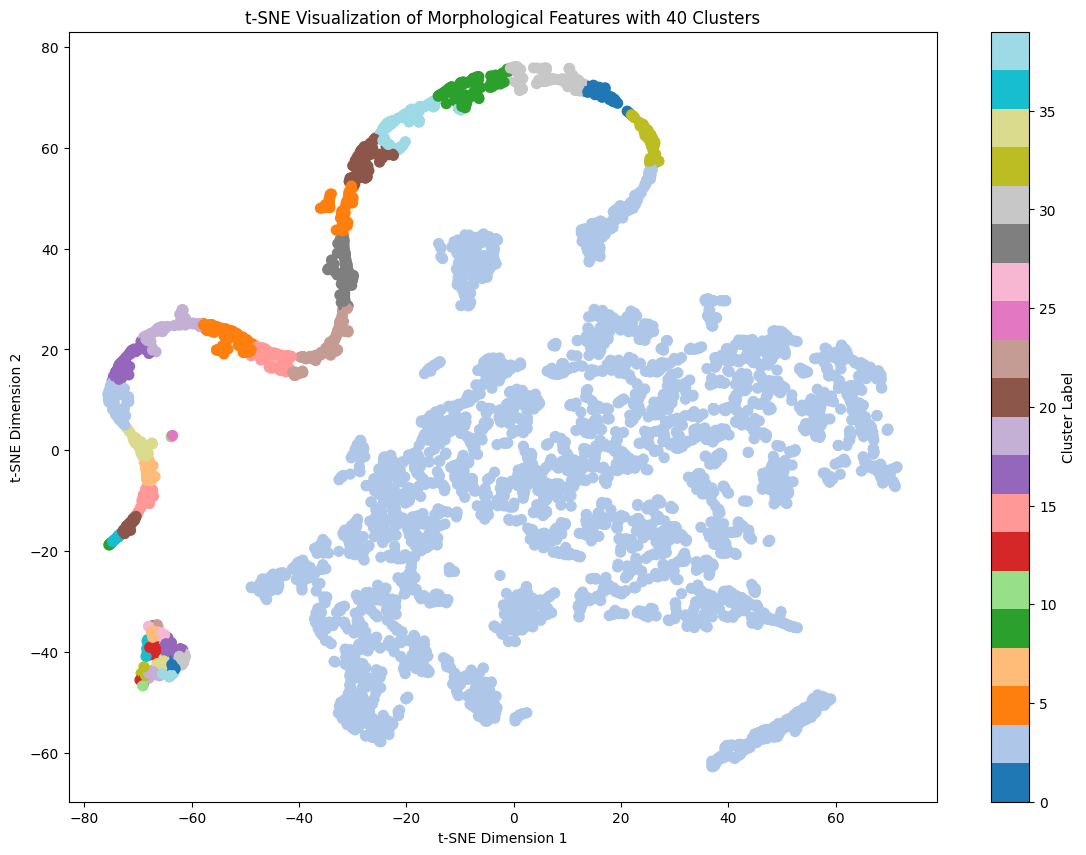

In [98]:
# Apply KMeans clustering with 40 clusters
kmeans = KMeans(n_clusters=40, random_state=42)
cluster_labels = kmeans.fit_predict(features_array_morphological)

# Reduce dimensionality for visualization using t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(features_array_morphological)

# Visualize the clusters
plt.figure(figsize=(14, 10))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=cluster_labels, cmap='tab20', s=50)
plt.colorbar(scatter, label='Cluster Label')
plt.title('t-SNE Visualization of Morphological Features with 40 Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

In [6]:
X_train, X_test, y_train, y_test = feature_reduction(features_array_morphological, labels_array_morphological, method='pca', n_components=0.95)

model = SVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

create_classification_report(y_test, y_pred, target_names, "SVM Model")

NameError: name 'features_array_morphological' is not defined